In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys,os
import h5py

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [2]:
hps_path = r'../../../hpsample_stride1.h5'
print(h5py.File(hps_path).keys())
hps_df = pd.read_hdf(hps_path, key='hyperparameters').reset_index()

<KeysViewHDF5 ['hyperparameters']>


In [3]:
summary_path = r'../CLN/summary.h5'
print(h5py.File(summary_path).keys())
timescales = pd.read_hdf(summary_path, key='timescales').reset_index()
vamps = pd.read_hdf(summary_path, key='vamps').reset_index()
timescale_ratio = pd.read_hdf(summary_path, key='timescale_ratio').reset_index()
timescale_gradient = pd.read_hdf(summary_path, key='timescale_gradient').reset_index()

<KeysViewHDF5 ['summary', 'timescale_gradient', 'timescale_ratio', 'timescales', 'vamps']>


In [4]:
print(timescales['hp_ix'].unique().shape)
print(hps_df['hp_ix'].unique().shape)
print(vamps['hp_ix'].unique().shape)
print(hps_df['feature__value'].unique())
print(hps_df['dihedrals__which'].unique())
print(hps_df['distances__scheme'].unique())
print(hps_df['distances__transform'].unique())
print(hps_df['tica__dim'].unique())
print(hps_df['tica__lag'].unique())
print(hps_df['cluster__k'].unique())

(131,)
(140,)
(131,)
['dihedrals' 'distances']
['all' nan]
[nan 'closest-heavy' 'ca']
[nan 'logistic' 'linear']
[19  4 18 15  7 13 16 20  5 10  6 11 14  2 12 17  8  3  9  1]
[ 36  93  68  94  87  19  99  14  79  21  74  43 100  33  40  60  23  73
  98  51  22  15  91  86  83  92  76  42  81  75  53  72  44  67  13  59
  88  69  61  25  35  57  11  38  41  71  12  65  80  52  20  34  46  56
   4  10  24  77  66  64   6  39  37   3  84  62  95  48   5  90  29  17
   9  47   1  30]
[306 251  98 441 104 275 471 368 231  75 375 153 257 136 101  92 244 220
  63 265 270 464 148  79 456 389 434  65 134 222 213  66 300 483 495 196
  99 237 384  38 255 122 392 474 254 285 302 110 224 278 488 315 192 445
 485 177 245 336 423 382 146 322 383 276  47  73  23 273 103 238  35 105
 380 162 411 391 332 359 219 406  34 329 459 154 479 223 312 489 165 197
 328 241  31  55  32 377 370 429 125 277 433 453 169 181 325 157 499  17
  70 452 337 381 399 289  61 385 393 348 398 160 387 193]


***
### Determine Markov lag

In [6]:
timescale_gradient = timescale_ratio.merge(hps_df, on='hp_ix', how='left')
timescale_gradient.dropna(subset='median', inplace=True)
timescale_gradient.query('process == 2', inplace=True)

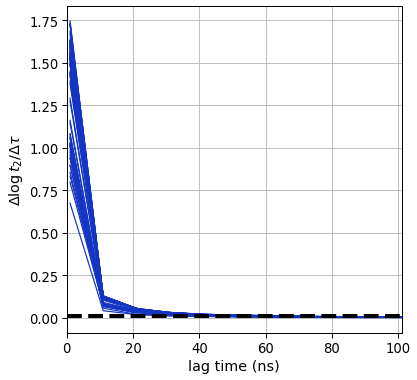

In [166]:
with sns.plotting_context('paper', font_scale=1.5):
    fig, ax = plt.subplots(figsize=(6, 6))
    for ix in ix_all:
        df = timescale_gradient.query(f'hp_ix == {ix}').sort_values(by='lag')
        if df.lag.unique().shape[0] > 1 and ((np.array(df['lag'][1:]) - np.array(df['lag'][:-1])) == 10).all():
            ax.plot(df['lag'], np.log10(df['median'])/df['lag'], c = '#1434c4')
    ax.set_xlim([0,101])
    ax.hlines(np.log(1.01), 0, 101, ls='dashed', color='k', label='$\log(1.01)$', linewidth=4)
    ax.grid(visible=True, axis='both')
    ax.set_xlabel('lag time (ns)')
    ax.set_ylabel('$\Delta\log{t_{2}}/\Delta\\tau$')
    plt.savefig(f'../CLN/timescale_gradient.png', bbox_inches='tight')

***
### Timescale distribution at different Markov lags

In [5]:
data_tica = timescales.merge(hps_df, on='hp_ix', how='left')
data_vamp = vamps.merge(hps_df, on='hp_ix', how='left')

data_tica['feature'] = data_tica['feature__value']+data_tica['distances__transform'].apply(lambda x: f"-{x}" if type(x)==str else "")
data_tica[r'$\log{t_{2}}$']= np.log10(data_tica['median'])
feature_names = {'dihedrals': 'dihed.', 'distances-linear': 'dist.', 'distances-logistic': 'logit(dist.)'}
data_tica['feature'] = data_tica['feature'].apply(lambda x: feature_names[x])
data_tica.drop(columns = ['dihedrals__which','distances__scheme','distances__transform','tica__stride','tica__kinetic_map'
                    ,'cluster__max_iter','cluster__stride'], inplace = True)

/tmp/ipykernel_16924/3385640567.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(data=data_tica.query(f'process == {p}'), hue='feature', col='lag', x=r'$\log{t_{2}}$', kind='kde')
/tmp/ipykernel_16924/3385640567.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(data=data_tica.query(f'process == {p}'), hue='feature', col='lag', x=r'$\log{t_{2}}$', kind='kde')
/tmp/ipykernel_16924/3385640567.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(data=data_tica.query(f'process == {p}'), hue='feature', col='lag', x=r'$\log{t_{2}}$', kind='kde')
/tmp/ipykernel_16924/3385640567.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(data=data_tica.query(f'process 

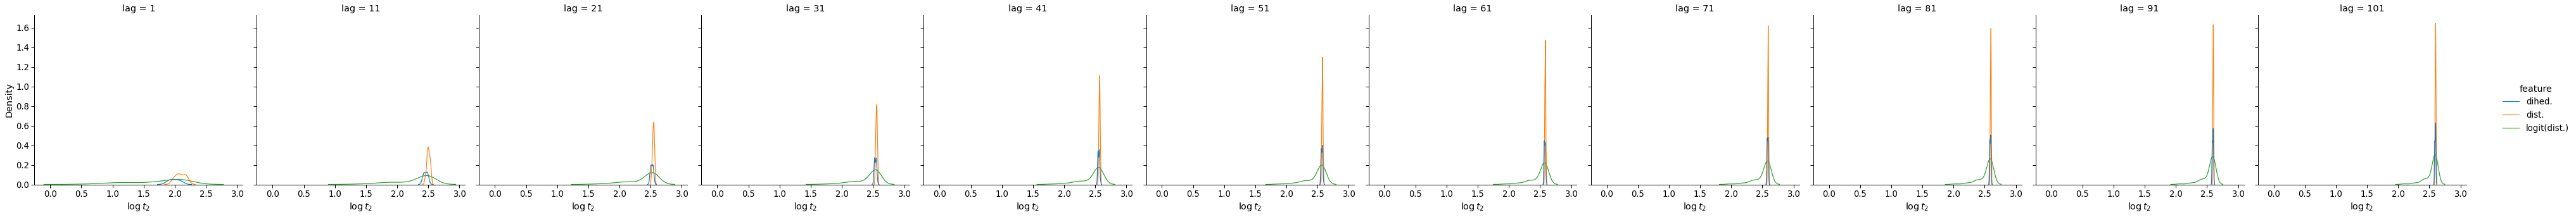

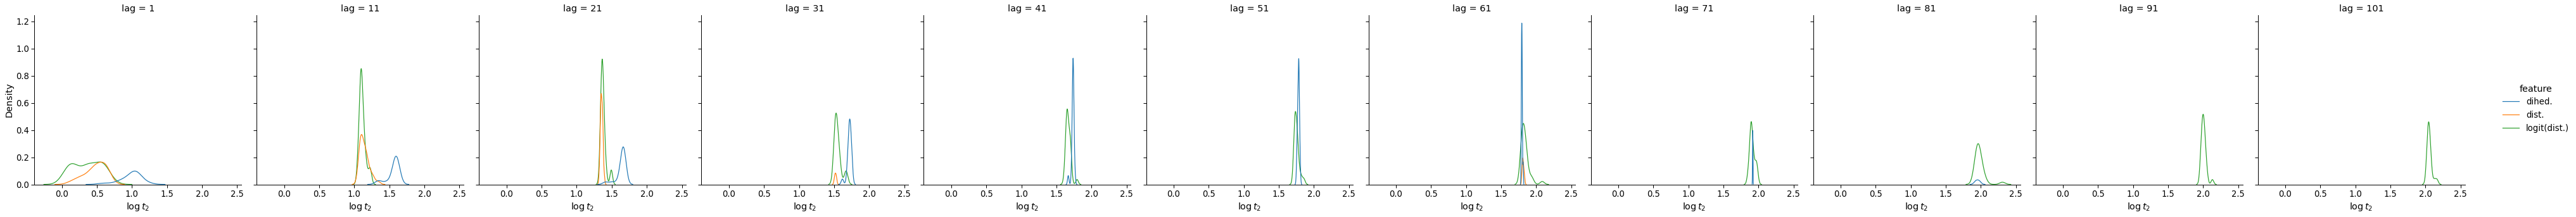

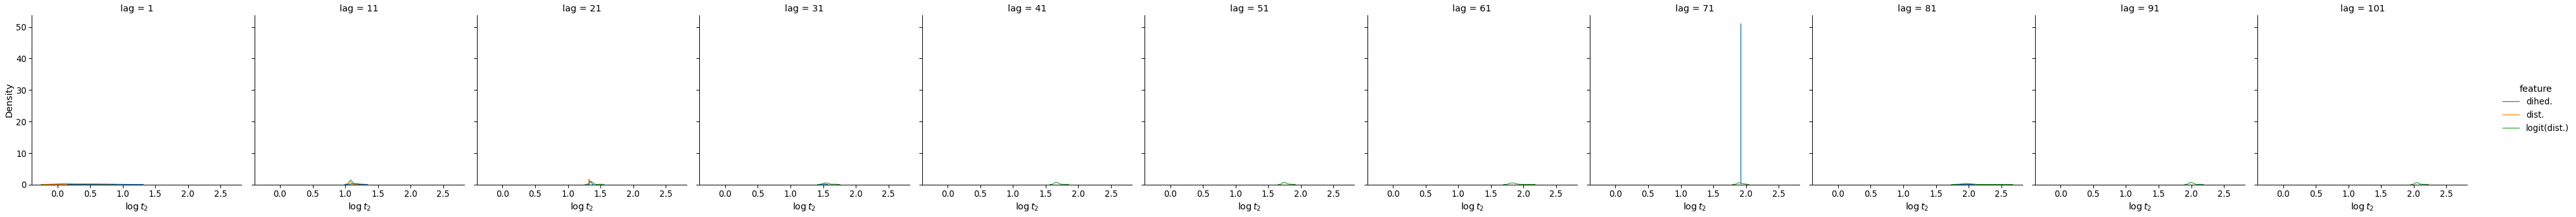

In [168]:
for p in [2,3,4]:
    with sns.plotting_context('paper', font_scale=1.5):
        sns.displot(data=data_tica.query(f'process == {p}'), hue='feature', col='lag', x=r'$\log{t_{2}}$', kind='kde')
    plt.savefig(f'../CLN/timescale_{p}_dist_summary.png', bbox_inches='tight')

***
### Best performing trials

In [6]:
# Rank trails according to the 2nd timescales
lag = 31
data = data_tica.query("process==2").query(f'lag=={lag}')
data.sort_values(by='median', inplace=True, axis=0, ascending=False)
data['rank'] = (np.arange(data.shape[0])+1).astype(int)
data

,hp_ix,lag,process,median,lb,ub,count,tica__dim,tica__lag,cluster__k,feature__value,distances__steepness,distances__centre,feature,$\log{t_{2}}$,rank
236,74,31,2,379.427824,296.450766,469.664699,100,15,71,488,distances,0.000000,0.000000,dist.,2.579129,1
4296,85,31,2,378.901482,294.835108,470.007656,100,19,52,485,distances,0.000000,0.000000,dist.,2.578526,2
981,131,31,2,377.822741,295.686109,467.770069,100,18,39,380,distances,0.000000,0.000000,dist.,2.577288,3
3003,24,31,2,377.699822,294.455989,466.445466,100,20,60,471,distances,6.081760,0.224891,logit(dist.),2.577147,4
3200,60,31,2,376.557178,291.756685,465.965134,100,11,19,285,distances,0.000000,0.000000,dist.,2.575831,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2401,183,31,2,109.627366,100.357366,118.676078,100,8,40,328,distances,46.678902,1.458448,logit(dist.),2.039919,127
3558,43,31,2,86.732057,78.654107,92.813997,100,10,88,38,distances,43.637496,1.232005,logit(dist.),1.938180,128
3403,135,31,2,85.754788,79.888367,91.574037,100,15,46,411,distances,16.686443,1.491501,logit(dist.),1.933258,129
626,22,31,2,69.385336,64.041383,74.553986,100,6,22,148,distances,33.504009,1.350308,logit(dist.),1.841268,130


In [7]:
# There are 9 failing trials 
df = hps_df.merge(data, how = 'outer',indicator=True).loc[lambda x : x['_merge']=='left_only']
df

,hp_ix,cluster__max_iter,cluster__stride,tica__dim,tica__lag,tica__kinetic_map,tica__stride,cluster__k,feature__value,dihedrals__which,distances__scheme,distances__transform,distances__steepness,distances__centre,lag,process,median,lb,ub,count,feature,$\log{t_{2}}$,rank,_merge
19,19,1000,1,19,73,True,1,265,distances,NaN,closest-heavy,logistic,14.455545,1.409263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
49,65,1000,1,15,35,True,1,302,distances,NaN,ca,logistic,34.545317,0.218626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
50,67,1000,1,18,57,True,1,110,distances,NaN,ca,logistic,33.533580,0.313319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
77,123,1000,1,20,64,True,1,238,distances,NaN,closest-heavy,logistic,45.287276,1.313132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
106,195,1000,1,19,42,True,1,302,distances,NaN,closest-heavy,logistic,21.264394,1.439302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
118,229,1000,1,5,44,True,1,325,distances,NaN,ca,logistic,39.019829,0.232738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
122,240,1000,1,4,37,True,1,70,distances,NaN,ca,logistic,43.321238,0.251898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
129,267,1000,1,12,23,True,1,61,distances,NaN,ca,logistic,24.883934,0.225061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
139,328,1000,1,5,30,True,1,193,distances,NaN,ca,logistic,31.227324,0.263639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [9]:
# Find the best performing hypepraramter. 1 for each feature scheme.
# dist.74 --- logit(dist.)24 --- dihed6

for f in data.feature.unique():
    print(f, '\n', data.query(f"feature=='{f}'").iloc[0,:],'\n')

dist. 
 hp_ix                           74
lag                             31
process                          2
median                  379.427824
lb                      296.450766
ub                      469.664699
count                          100
tica__dim                       15
tica__lag                       71
cluster__k                     488
feature__value           distances
distances__steepness           0.0
distances__centre              0.0
feature                      dist.
$\log{t_{2}}$             2.579129
rank                             1
Name: 236, dtype: object 

logit(dist.) 
 hp_ix                             24
lag                               31
process                            2
median                    377.699822
lb                        294.455989
ub                        466.445466
count                            100
tica__dim                         20
tica__lag                         60
cluster__k                       471
feature__value      

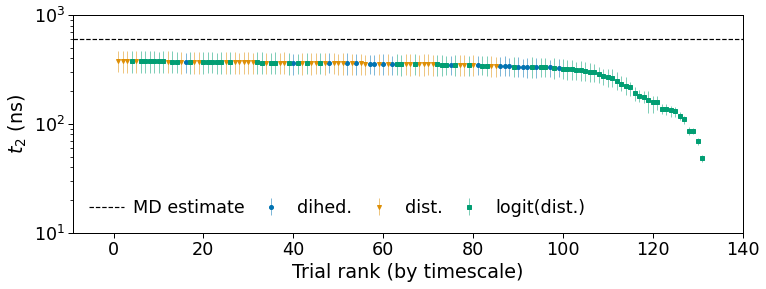

In [13]:
with sns.plotting_context('paper', font_scale=2):
    cols = sns.color_palette('colorblind')
    shapes = ['o', 'v', 's']
    xlim = [-9, 140]
    ylim = [10, 1000]
    hp_ix_cutoff = 329 # the indices where the optimized trials start
    incumbent_1 = -np.inf
    incumbent_2 = -np.inf
    
    fig, axes = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(12, 4))
    for i, feat in enumerate(np.sort(data.feature.unique())): 
        
        # Pre optimization
        
        #ix = (data.feature==feat) & (data.hp_ix.isin(groups[group_num]))
        ix = data.feature==feat
        y = data.loc[ix, 'median']
        yerr = (y-data.loc[ix, 'lb'], data.loc[ix, 'ub']-y)
        x = data.loc[ix, 'rank']
        axes.errorbar(x, y, yerr, elinewidth=0.5, lw=0, marker=shapes[i], markersize=4, color=cols[i], label=feat)
        
        #axes.grid(visible=True, axis='y')
        axes.set_xlim(xlim)
        axes.set_ylim(ylim)
        axes.set_ylabel('$t_{2}$ (ns)')
        axes.set_yscale('log')
        axes.set_xlabel('Trial rank (by timescale)')
        #axes.annotate(text="(a)", xy=(0.02, 0.95), xycoords='axes fraction', ha='left', va='top')
    
    axes.hlines(600, xlim[0], xlim[1], ls='dashed', color='k', label='MD estimate')
        
    axes.legend(bbox_to_anchor=(0, 0), loc='lower left', ncol=4, frameon=False, handletextpad=0.5,  columnspacing=0.5)

plt.savefig(f'../CLN/timescale_distribution_lag_{lag}.png', bbox_inches='tight')